In [1]:
from dataclasses import dataclass
import itertools
import logging
import random
import math
import numpy as np
import json
import pickle
import time
import torch
import sys
import yaml
import seaborn as sns
import matplotlib.pyplot as plt
from probe_utils import *

from omegaconf import OmegaConf
from pathlib import Path
from torch import nn, Tensor
from torch.nn import functional as F
from typing import List, Optional, Tuple
import os
# os.chdir("/data/tianyu_guo/birth")
from data import DataArgs, Dataset, iterate_batches, make_dataset
from ihead_full_model import ModelArgs, Transformer, forward_hook, test_value, test_sink, zero_out_attention
from plot_utils import *

%load_ext autoreload
%autoreload 2


In [2]:
seeds = [27, 42]
run_path_server = "/data/tianyu_guo/birth/gens/pre-iclr/multi-head/dormant_copy_k3_bos1"
# run_path_server2="/data/tianyu_guo/birth/gens/special/dormant_copy_2"
model, cfg, x, y, ds = load_model(run_path_local="/Users/guotianyu_guo/GitHub/birth/gens/special/markov", run_path_server=run_path_server, n_layers=7, n_heads=4, bos_num=1, train_steps=10000, delim=0, with_data=True, data_path_local="/Users/guotianyu_guo/GitHub/birth/data", data_path_server="/data/tianyu_guo/birth/data", seeds=seeds)
x_ood = ds.gen_batch_ood(rng=np.random.default_rng(seeds), batch_size=cfg.optim_args.batch_size, drop=[0])
x_ood = torch.from_numpy(x_ood)
y_ood = x_ood[:, 1:]
x_ood = x_ood[:, :-1]
hook = forward_hook([], None)
_, outputs_list_proto = model.modified_forward_with_hook(x, hook)

In [7]:
rng = np.random.default_rng(27)
# hook = zero_out_attention(target_layers=[1, 2], target_heads=[(1, 0), (1, 1), (1, 2), (1, 3), (2, 0), (2, 1), (2, 3)])
# hook = zero_out_attention(target_layers=[1, 2], target_heads=[(2, 0), (2, 2), (2, 3)])
# hook = zero_out_attention(target_layers=[1, 2, 3, 4], target_heads=[(2, 0), (2, 1), (2, 2), (2, 3), (3, 0), (3, 1), (3, 2), (3, 3), (4, 0), (4, 1), (4, 2), (4, 3), (5, 0), (5, 1), (5, 2), (5, 3)])
hook = zero_out_attention(target_layers=[1, 2, 3, 4, 5], target_heads=[(2, 1), (2, 2), (4, 0), (4, 2), (4, 3), (5, 2), (5, 3)])
probs = get_oracle_predicts(x, ds)
ood_probs = get_oracle_predicts(x_ood, ds)

predicts, outputs_list = model.modified_forward_with_hook(x, hook)
ood_predicts, ood_outputs_list = model.modified_forward_with_hook(x_ood, hook)
triggers_pos = ds.get_triggers_pos(x)
triggers_pos_ood = ds.get_triggers_pos(x_ood)

risk = get_risk(probs, predicts, predict_in_logits=True, triggers_pos=triggers_pos)
risk_oracle = get_risk(probs, probs, predict_in_logits=False, triggers_pos=triggers_pos)
risk_ood = get_risk(ood_probs, ood_predicts, predict_in_logits=True, triggers_pos=triggers_pos_ood)
risk_ood_oracle = get_risk(ood_probs, ood_probs, predict_in_logits=False, triggers_pos=triggers_pos_ood)

risk[1:3], risk_oracle[1:3], risk_ood[1:3], risk_ood_oracle[1:3]

((tensor(5.8680, grad_fn=<MeanBackward0>),
  tensor(2.2309, grad_fn=<MeanBackward0>)),
 (tensor(0.), tensor(2.2203)),
 (tensor(5.8602, grad_fn=<MeanBackward0>),
  tensor(2.0629, grad_fn=<MeanBackward0>)),
 (tensor(0.), tensor(2.0435)))

In [225]:
risk_by_token = dict([(idx, []) for idx in ds.tok_range])
for seq_idx in range(256):
    ids = x[seq_idx, [idx-1 for idx, f in enumerate(triggers_pos[seq_idx, :]) if f]].tolist()
    risks = risk[0][seq_idx, [idx for idx, f in enumerate(triggers_pos[seq_idx, :]) if f]].tolist()
    for id, r in zip(ids, risks):
        risk_by_token[id].append(r)
for idx, r in risk_by_token.items():
    if len(r)>0:
        risk_by_token[idx] = np.mean(risk_by_token[idx])
risk_by_token_1234 = risk_by_token

In [226]:
rng = np.random.default_rng(27)
# hook = zero_out_attention(target_layers=[1, 2], target_heads=[(1, 0), (1, 1), (1, 2), (1, 3), (2, 0), (2, 1), (2, 3)])
# hook = zero_out_attention(target_layers=[1, 2], target_heads=[(2, 0), (2, 2), (2, 3)])
hook = zero_out_attention(target_layers=[1, 2, 3, 4], target_heads=[(2, 0), (2, 1), (2, 2), (2, 3), (3, 0), (3, 1), (3, 2), (3, 3), (4, 1), (4, 2), (4, 3), (5, 0), (5, 1), (5, 2), (5, 3)]) -> loss=10
hook_2 = zero_out_attention(target_layers=[1, 2, 3, 4], target_heads=[(2, 0), (2, 1), (2, 2), (2, 3), (3, 0), (3, 1), (3, 2), (3, 3), (4, 2), (4, 3), (5, 0), (5, 1), (5, 2), (5, 3)]) -> loss=0
hook_3 = zero_out_attention(target_layers=[1, 2, 3, 4], target_heads=[(2, 0), (2, 1), (2, 2), (2, 3), (3, 0), (3, 1), (3, 2), (3, 3), (4, 1)]) -> loss=10
# hook = zero_out_attention(target_layers=[1, 2], target_heads=[(4, 0), (4, 1), (4, 2)])
probs = get_oracle_predicts(x, ds)
ood_probs = get_oracle_predicts(x_ood, ds)

predicts, outputs_list = model.modified_forward_with_hook(x, hook)
ood_predicts, ood_outputs_list = model.modified_forward_with_hook(x_ood, hook)
triggers_pos = ds.get_triggers_pos(x)
triggers_pos_ood = ds.get_triggers_pos(x_ood)

risk = get_risk(probs, predicts, predict_in_logits=True, triggers_pos=triggers_pos)
risk_oracle = get_risk(probs, probs, predict_in_logits=False, triggers_pos=triggers_pos)
risk_ood = get_risk(ood_probs, ood_predicts, predict_in_logits=True, triggers_pos=triggers_pos_ood)
risk_ood_oracle = get_risk(ood_probs, ood_probs, predict_in_logits=False, triggers_pos=triggers_pos_ood)

risk[1:3], risk_oracle[1:3], risk_ood[1:3], risk_ood_oracle[1:3]

((tensor(3.7340, grad_fn=<MeanBackward0>),
  tensor(2.2311, grad_fn=<MeanBackward0>)),
 (tensor(0.), tensor(2.2203)),
 (tensor(4.3715, grad_fn=<MeanBackward0>),
  tensor(2.0684, grad_fn=<MeanBackward0>)),
 (tensor(0.), tensor(2.0435)))

In [231]:
risk_by_token = dict([(idx, []) for idx in ds.tok_range])
for seq_idx in range(256):
    ids = x[seq_idx, [idx-1 for idx, f in enumerate(triggers_pos[seq_idx, :]) if f]].tolist()
    risks = risk[0][seq_idx, [idx for idx, f in enumerate(triggers_pos[seq_idx, :]) if f]].tolist()
    for id, r in zip(ids, risks):
        risk_by_token[id].append(r)
for idx, r in risk_by_token.items():
    if len(r)>0:
        risk_by_token[idx] = np.mean(risk_by_token[idx])
risk_by_token_123 = risk_by_token

In [232]:
for idx, value in risk_by_token_123.items():
    if isinstance(value, list):
        risk_by_token_123[idx] = 0
for idx, value in risk_by_token_1234.items():
    if isinstance(value, list):
        risk_by_token_1234[idx] = 0

<BarContainer object of 67 artists>

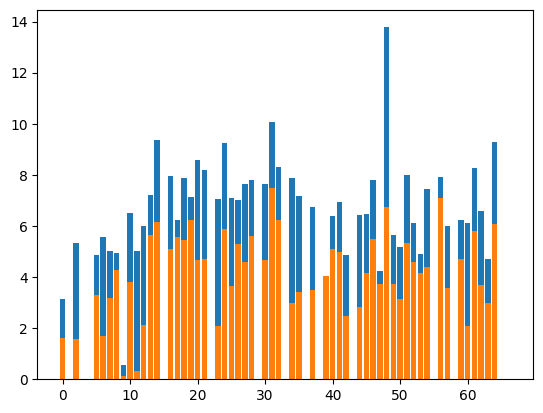

In [233]:
plt.bar(risk_by_token_1234.keys(), risk_by_token_1234.values())
plt.bar(risk_by_token_123.keys(), risk_by_token_123.values())

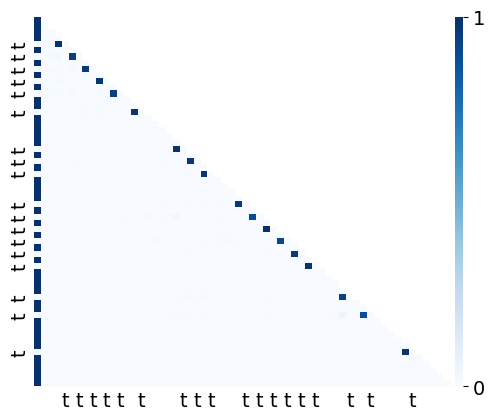

In [142]:
plot_attn_weights(outputs_list_proto, x, ds, [0], 60, 2, 1, seq_start=0, keep_label=[], ticks_size=14, titles=[], save_files_fn=[], fn=None)

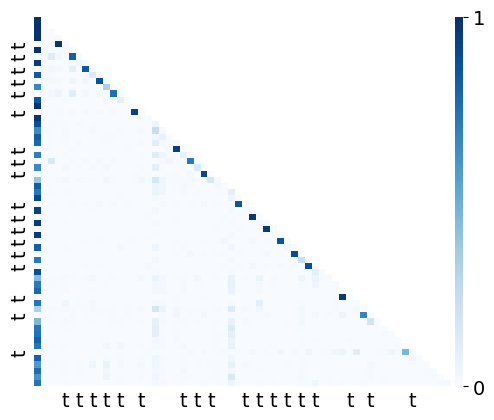

In [143]:
plot_attn_weights(outputs_list_proto, x, ds, [0], 60, 2, 0, seq_start=0, keep_label=[], ticks_size=14, titles=[], save_files_fn=[], fn=None)

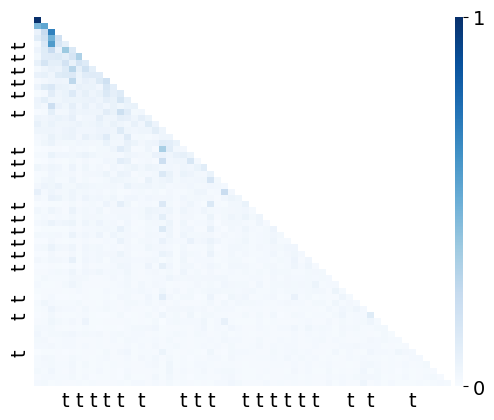

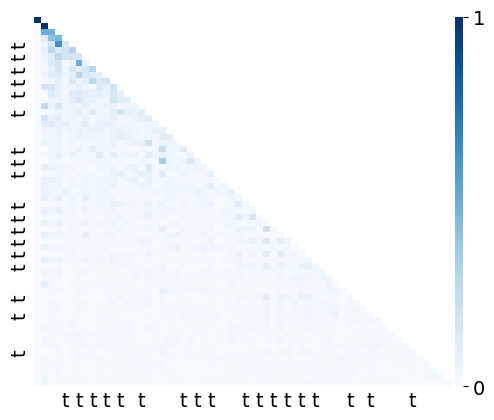

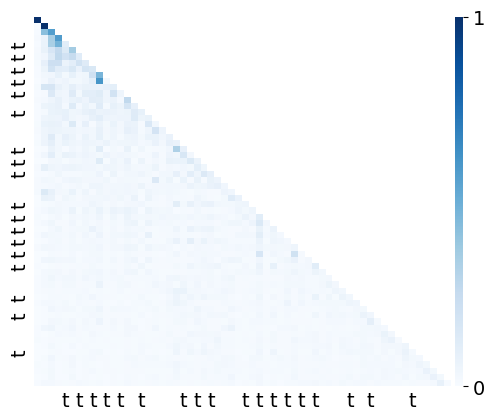

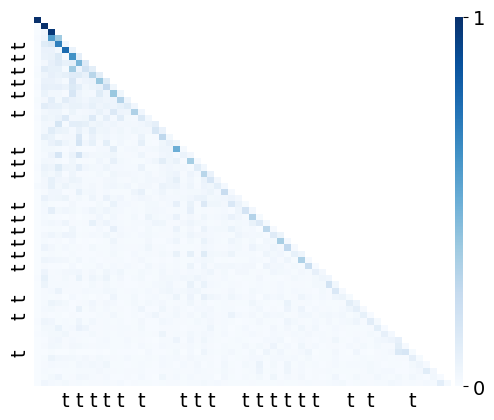

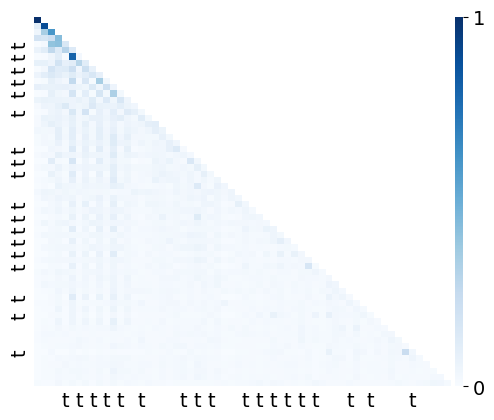

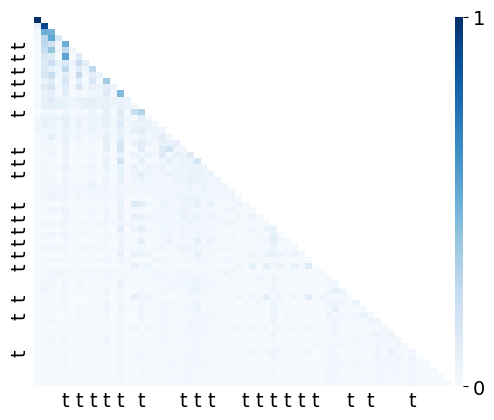

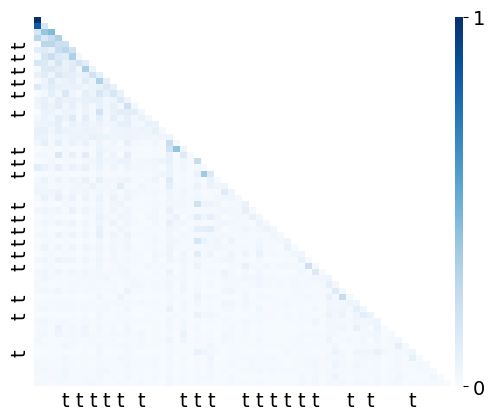

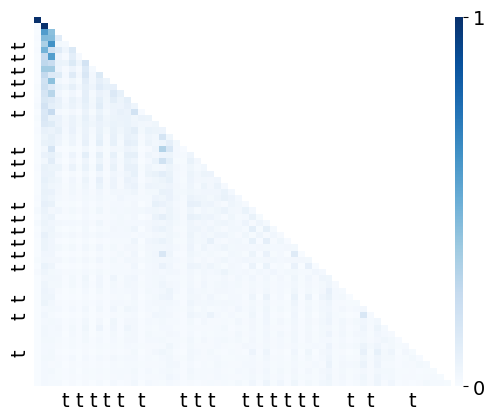

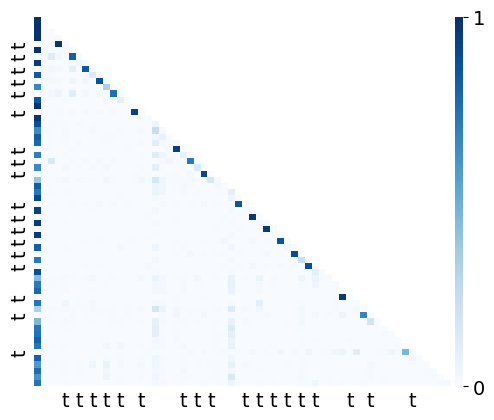

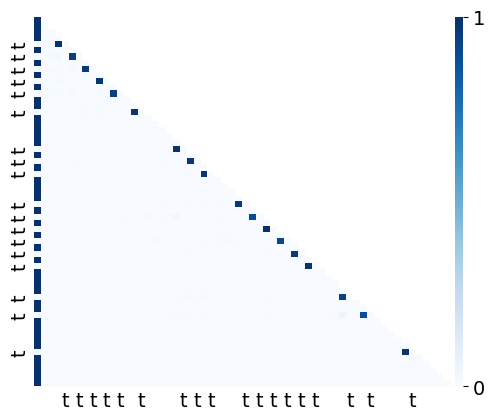

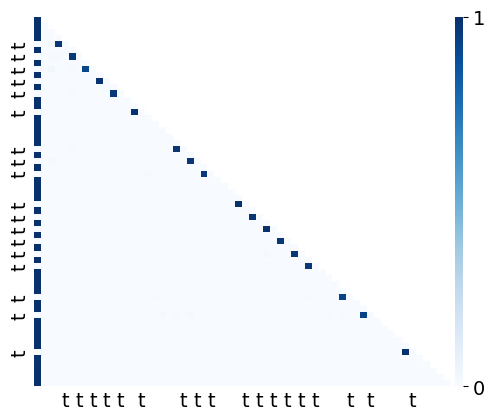

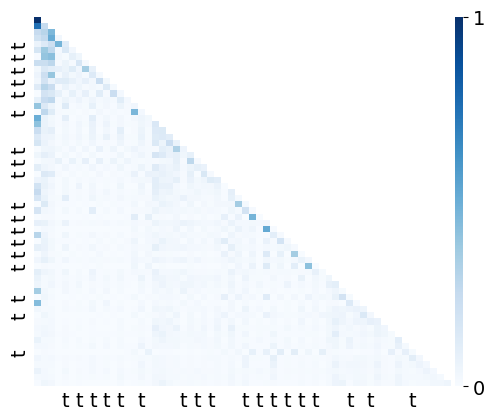

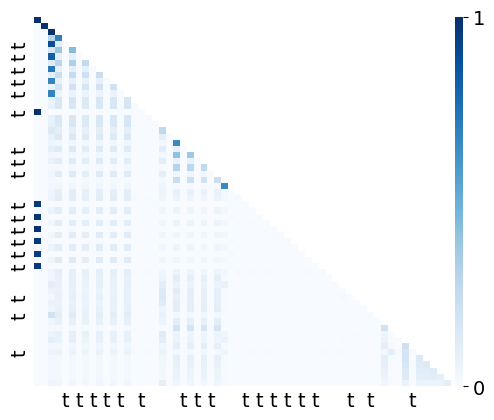

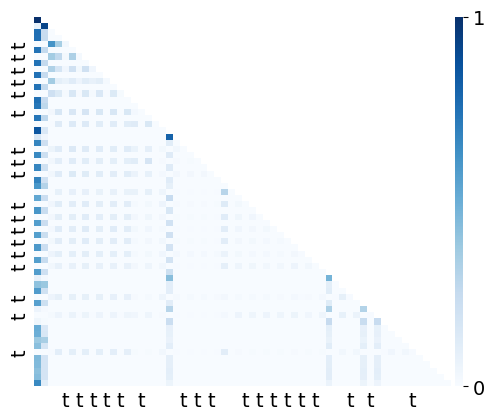

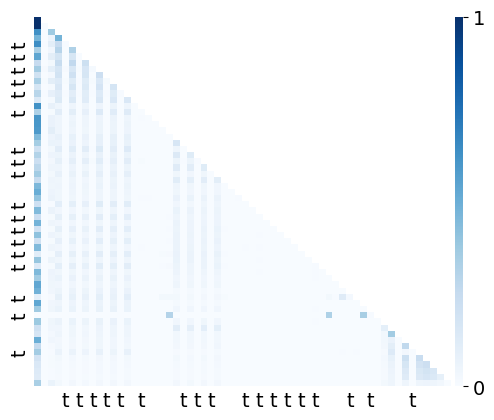

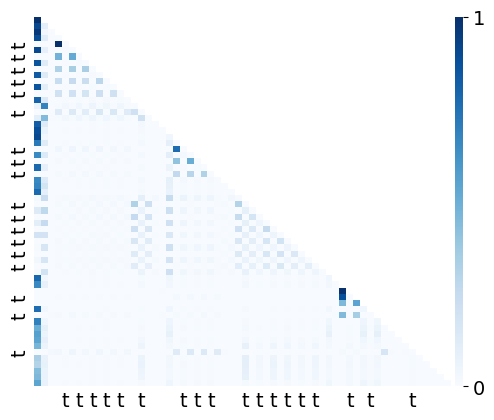

In [145]:
for layer_idx in range(4):
    for head_idx in range(4):
        plot_attn_weights(outputs_list_proto, x, ds, [0], 60, layer_idx, head_idx, seq_start=0, keep_label=[], ticks_size=14, titles=[], save_files_fn=[], fn=None)